In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

%matplotlib inline

# Mock up some data

In [2]:
cov = [[1, 0], [0, 1]]

Xs = []
ys = []
num_classes = 3
for i in range(num_classes):
    X = np.random.multivariate_normal([i * 7, 0 if i % 2 == 0 else 1.5], cov, 100)
    y = [i + 1] * 100
    Xs.append(X)
    ys.append(y)
Xs = np.concatenate(Xs)
ys = np.concatenate(ys)

df = pd.DataFrame(Xs, columns=['fea1', 'fea2'])
df['label'] = ys
labels = np.sort(np.unique(ys))

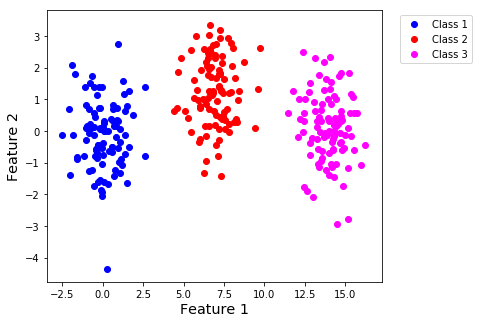

In [3]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

colors = ['blue', 'red', 'magenta']
for k, lb in enumerate(labels):
    _df = df.query('label == {0}'.format(lb))
    ax.scatter(_df.fea1.values, _df.fea2.values, c=colors[k], label='Class {0}'.format(lb))

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# for use later
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# OVR linear model cannot separate Class 2 from the rest effectively 

In [4]:
def get_line_coords(clf):
    w1, w2 = clf.coef_[0]
    b = clf.intercept_
    xs = np.arange(-20, 30)
    ys = (-b - w1 * xs) / w2
    return xs, ys

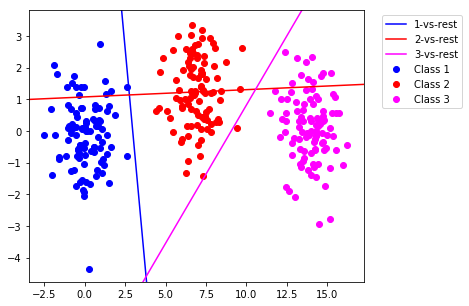

In [5]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

colors = ['blue', 'red', 'magenta']

ndf = df[['fea1', 'fea2', 'label']].copy()
for k, lb in enumerate(labels):
    _df = df.query('label == "{0}"'.format(lb))
    ax.scatter(_df.fea1.values, _df.fea2.values, c=colors[k], label='Class {0}'.format(lb))
    
    # plot trained decision boundries
    ndf['label'] = df.label.apply(lambda v: str(lb) if v == lb else 'rest')
    nclf = LogisticRegression(tol=1e-10).fit(ndf[['fea1', 'fea2']], ndf['label'])
    lxs, lys = get_line_coords(nclf)
    ax.plot(lxs, lys, c=colors[k], label='{0}-vs-rest'.format(lb))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

### Show one-vs-rest individually

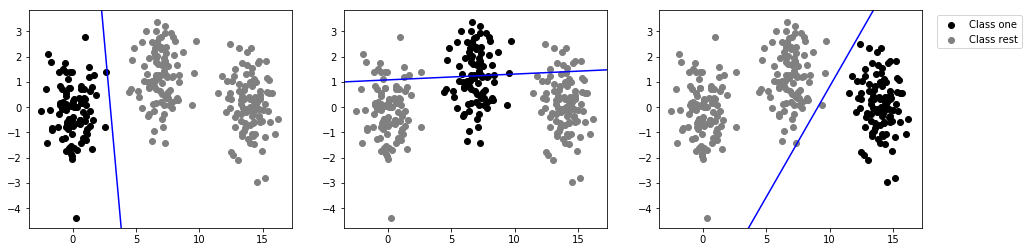

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.ravel()

colors = ['black', 'grey']

ndf = df[['fea1', 'fea2', 'label']].copy()
for k, lb in enumerate(labels):
    ax = axes[k]
    
#     _df = df.query('label == "{0}"'.format(lb))
#     ax.scatter(_df.fea1.values, _df.fea2.values, c=colors[k], label='Class {0}'.format(lb))
    
    # plot trained decision boundries
    ndf['label'] = df.label.apply(lambda v: 'one' if v == lb else 'rest')
    for ki, i in enumerate(np.sort(ndf.label.unique())):
        _df = ndf.query('label == "{0}"'.format(i))
        ax.scatter(_df.fea1.values, _df.fea2.values, c=colors[ki], label='Class {0}'.format(i))
    
    nclf = LogisticRegression(tol=1e-10).fit(ndf[['fea1', 'fea2']], ndf['label'])
    lxs, lys = get_line_coords(nclf)
    ax.plot(lxs, lys, c='blue', label='')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

See the failure when separating the magenta classes from the rest

# Now demonstrate OVO

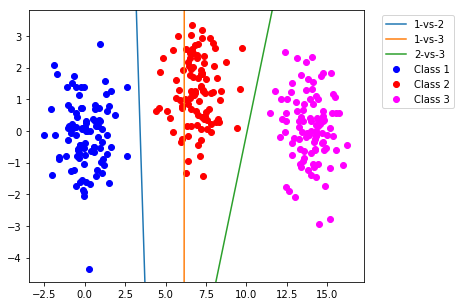

In [10]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

colors = ['blue', 'red', 'magenta']
for k1, d1 in enumerate(labels):
    # scatter all classes
    _df = df.query('label == "{0}"'.format(d1))
    ax.scatter(_df.fea1.values, _df.fea2.values, c=colors[k1], label='Class {0}'.format(d1))
    for k2, d2 in enumerate(labels):
        if d1 >= d2:
            continue

        # plot trained decision boundries
        _df = df.query('label in {0}'.format([d1, d2])).copy()
        _clf = LogisticRegression(C=100, tol=1e-10).fit(_df[['fea1', 'fea2']], _df['label'])
        lxs, lys = get_line_coords(_clf)
        ax.plot(lxs, lys, label='{0}-vs-{1}'.format(d1, d2))

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

### Show one-vs-one individually

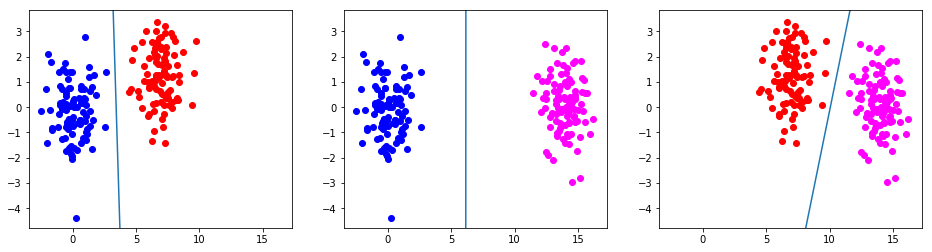

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.ravel()

colors = dict(zip(labels, ['blue', 'red', 'magenta']))
counter = 0

for k1, d1 in enumerate(labels):
    # scatter all classes
    _df = df.query('label == "{0}"'.format(d1))
    for k2, d2 in enumerate(labels):
        if d1 >= d2:
            continue
        ax = axes[counter]
        counter += 1
            
        # plot trained decision boundries
        _df = df.query('label in {0}'.format([d1, d2])).copy()
        for ki, i in enumerate([d1, d2]):
            _dfi = _df.query('label == "{0}"'.format(i))
            ax.scatter(_dfi.fea1.values, _dfi.fea2.values, c=colors[i], label='Class {0}'.format(i))
        
        _clf = LogisticRegression(C=100, tol=1e-10).fit(_df[['fea1', 'fea2']], _df['label'])
        lxs, lys = get_line_coords(_clf)
        ax.plot(lxs, lys, label='{0}-vs-{1}'.format(d1, d2))

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
# ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")